In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 40)

from vivarium_research_prl.noise import corruption, fake_names, noisify

!date
!whoami
!uname -a
!pwd

Thu 09 Feb 2023 10:50:17 PM PST
ndbs
Linux int-slurm-sarchive-p0002 5.4.0-89-generic #100-Ubuntu SMP Fri Sep 24 14:50:10 UTC 2021 x86_64 x86_64 x86_64 GNU/Linux
/mnt/share/code/ndbs/vivarium_research_prl/linkage/wic_case_study


In [2]:
%load_ext autoreload
%autoreload 2

# Goal: Assign zipcodes to new census data that only has address IDs

We can use use the zipcodes from the `2022_10_14_10_49_32` data that has both address and zipcode columns. The idea is to map each unique address ID in the new `2023_02_02_10_16_21` data to an address in the old data, then use the zipcode for that address. The goal is to have the relative number of addreses per zipcode be about the same as in the old data. I'm not concerned with getting address strings for the address IDs, because I can just convert each ID to a string and use that as the address for linking.

# Define directories

In [3]:
project_output_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop'
orig_data_subdir = 'results/special_last_names/florida/2022_10_14_10_49_32/population_table/'
orig_data_dir = f'{project_output_dir}/{orig_data_subdir}'

new_data_subdir = 'results/vv_post_processing_first_middle_names/united_states_of_america/2023_02_02_10_16_21/'
new_data_subsubdir = 'final_results/2023_02_02_11_10_52'
new_data_dir = f'{project_output_dir}/{new_data_subdir}/{new_data_subsubdir}'

!ls -l $orig_data_dir


total 32224
-rw-rw-r-- 1 albrja   IHME-Simulationscience 12622072 Oct 20 23:08 decennial_census.hdf
-rwxrwxrwx 1 beatrixh IHME-Simulationscience 20364830 Nov 14 16:42 state_table.hdf


# Load state table from original data

In [4]:
state_table_path = f'{orig_data_dir}/state_table.hdf'
df_state_table = pd.read_hdf(state_table_path, 'ymd_2020_4_1')
df_state_table

,tracked,middle_name,sex,relation_to_household_head,race_ethnicity,housing_type,exit_time,last_name,state,ssn,...,years_of_life_lost,cause_of_death,zipcode,address,parent_id,last_birth_time,employer_id,employer_name,employer_zipcode,employer_address
0,True,Jenny,Female,Reference person,Black,Standard,NaT,Clark,12,486-24-8278,...,0.0,not_dead,34601,"1344 winoka rd brooksville, fl",-1,2019-03-04 18:00:00,46,not implemented,33187,"2408 brookshire dr sunset corners, fl"
1,True,Virgil,Male,Reference person,Black,Standard,NaT,Littlejohn,12,108-89-8623,...,0.0,not_dead,34698,"927 23rd st clearwater, fl",-1,NaT,193,not implemented,33948,"144 tulip ln prt charlotte, fl"
2,True,Annaliese,Female,Biological child,Black,Standard,NaT,Jackson,12,788-05-3097,...,0.0,not_dead,34698,"927 23rd st clearwater, fl",-1,2019-03-04 18:00:00,-1,unemployed,NA,NA
3,True,Devyn,Male,Stepchild,Black,Standard,NaT,Cox,12,,...,0.0,not_dead,34698,"927 23rd st clearwater, fl",-1,NaT,204,not implemented,33169,"1835 harvard dr hialeah, fl"
4,True,Jonathan,Male,Reference person,White,Standard,NaT,Tucker,12,009-31-4192,...,0.0,not_dead,32003,"8904 167th place fleming island, fl",-1,NaT,176,not implemented,34293,"2607 e bluefield ave venice, fl"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,True,Nicholas,Male,Institutionalized GQ pop,White,Other institutional,NaT,Roberts,12,625-97-5353,...,0.0,not_dead,33919,"114 s frnt st fort myers, fl",-1,NaT,-1,unemployed,NA,NA
49996,True,John,Male,Institutionalized GQ pop,White,Carceral,NaT,Campbell,12,238-09-2208,...,0.0,not_dead,33021,"2210 henn hyde rd ne hollywood, fl",-1,NaT,-1,unemployed,NA,NA
49997,True,Charles,Male,Institutionalized GQ pop,Latino,Nursing home,NaT,Rosales,12,650-80-3526,...,0.0,not_dead,32968,"701 haber rd vero beach, fl",-1,NaT,-1,unemployed,NA,NA
49998,True,Jermaine,Male,Institutionalized GQ pop,White,Other institutional,NaT,Morton,12,784-92-1608,...,0.0,not_dead,33919,"114 s frnt st fort myers, fl",-1,NaT,19,not implemented,33444,"92 address unassigned delray beach, fl"


# Look at how addresses are distributed among zipcodes

In [5]:
address_counts = df_state_table.groupby('zipcode')['address'].nunique().sort_values()
address_counts

zipcode
cp34714      1
32420        1
32357        1
cp34110      1
32312        1
          ... 
33908      114
32218      120
33974      138
33993      154
34953      155
Name: address, Length: 864, dtype: int64

In [6]:
df_state_table.zipcode.value_counts()

33919      460
33993      406
34953      403
32968      358
33021      351
          ... 
cp34110      1
32445        1
33827        1
32024        1
33132        1
Name: zipcode, Length: 864, dtype: int64

<AxesSubplot: >

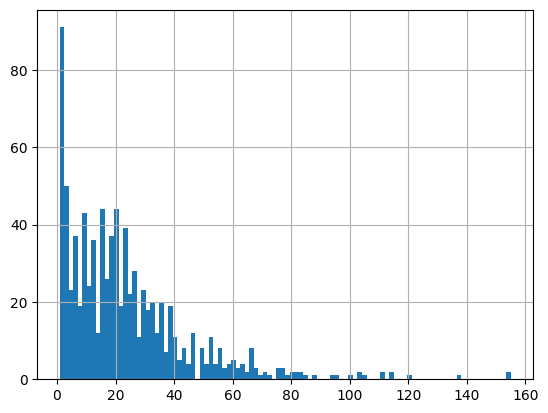

In [7]:
address_counts.hist(bins=100)

<AxesSubplot: >

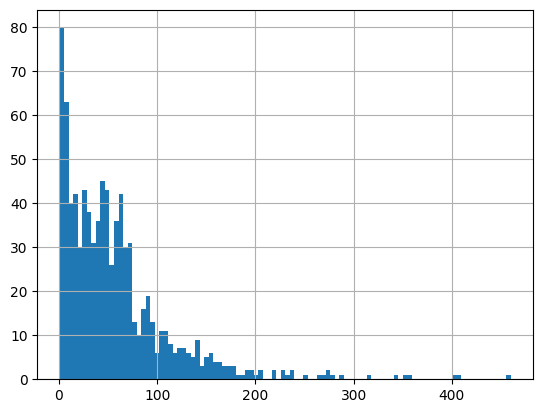

In [8]:
df_state_table.zipcode.value_counts().hist(bins=100)

In [9]:
# 55 zipcodes with only one address
# 1 zipcode with 155 addresses
address_counts.value_counts()

1      55
2      36
21     29
3      27
17     26
       ..
78      1
61      1
76      1
73      1
155     1
Name: address, Length: 93, dtype: int64

In [10]:
# 18 zipcodes occurring in only 2 rows
# 1 zipcode occurring in 460 rows
df_state_table.zipcode.value_counts().value_counts()

2      18
3      18
7      18
9      17
1      16
       ..
153     1
157     1
159     1
160     1
460     1
Name: zipcode, Length: 183, dtype: int64

# Write a function to clean non-standard zipcodes

In [11]:
df_state_table.loc[~df_state_table.zipcode.str.isdigit(), 'zipcode']

12102      cp 33440
14637       cp34110
16971       cp33415
16972       cp33415
16973       cp33415
16974       cp33415
23973    32223-1647
23974    32223-1647
27551      cp 33433
27552      cp 33433
27553      cp 33433
27554      cp 33433
27555      cp 33433
29098       cp32095
29099       cp32095
29100       cp32095
40350      cp 33409
40351      cp 33409
46411       cp34714
46412       cp34714
46413       cp34714
Name: zipcode, dtype: object

In [12]:
zipcodes = df_state_table.zipcode
all_digits = zipcodes.str.isdigit()
zipcodes.loc[~all_digits].str.strip('cp ') # Don't forget the space!

12102         33440
14637         34110
16971         33415
16972         33415
16973         33415
16974         33415
23973    32223-1647
23974    32223-1647
27551         33433
27552         33433
27553         33433
27554         33433
27555         33433
29098         32095
29099         32095
29100         32095
40350         33409
40351         33409
46411         34714
46412         34714
46413         34714
Name: zipcode, dtype: object

In [13]:
zipcodes[~all_digits].str.replace('-\d{4}', '', regex=True)

12102    cp 33440
14637     cp34110
16971     cp33415
16972     cp33415
16973     cp33415
16974     cp33415
23973       32223
23974       32223
27551    cp 33433
27552    cp 33433
27553    cp 33433
27554    cp 33433
27555    cp 33433
29098     cp32095
29099     cp32095
29100     cp32095
40350    cp 33409
40351    cp 33409
46411     cp34714
46412     cp34714
46413     cp34714
Name: zipcode, dtype: object

In [14]:
def clean_zipcode(zipcode):
    clean_zipcode = (
        zipcode
        .str.strip('cp ')
        .str.replace(r'-\d{4}', '', regex=True)
    )
    return clean_zipcode
clean_zips = clean_zipcode(zipcodes)
clean_zips

0        34601
1        34698
2        34698
3        34698
4        32003
         ...  
49995    33919
49996    33021
49997    32968
49998    33919
49999    32968
Name: zipcode, Length: 50000, dtype: object

In [15]:
clean_zips.loc[~all_digits]

12102    33440
14637    34110
16971    33415
16972    33415
16973    33415
16974    33415
23973    32223
23974    32223
27551    33433
27552    33433
27553    33433
27554    33433
27555    33433
29098    32095
29099    32095
29100    32095
40350    33409
40351    33409
46411    34714
46412    34714
46413    34714
Name: zipcode, dtype: object

## Check that cleaned zips are all 5-digit strings

In [16]:
clean_zips.str.isdigit().all()

True

In [17]:
(clean_zips.str.len() == 5).all()

True

# Look at employer addresses and zipcodes

It looks like every employer address is also a residential address, for some reason. And there are not many employer addresses compared to residential addresses. So there's no point in trying to include employer addresses and zipcodes in our data.

In [18]:
df_state_table.address.nunique()

20449

In [19]:
df_state_table.employer_address.nunique()

246

In [20]:
df_state_table.employer_zipcode.nunique()

207

In [21]:
zips = set(df_state_table.zipcode)
emp_zips = set(df_state_table.employer_zipcode)
emp_zips - zips

{'NA'}

In [22]:
# Why are all the employer addresses equal to residential addresses???
addresses = set(df_state_table.address)
emp_addresses = set(df_state_table.employer_address)
emp_addresses - addresses

{'NA'}

In [23]:
len(addresses - emp_addresses)

20204

In [24]:
emp_address_counts = (
    df_state_table
    .groupby('employer_zipcode')
    ['employer_address'].nunique()
    .sort_values()
)
emp_address_counts

employer_zipcode
32003    1
33610    1
33612    1
33614    1
33615    1
        ..
34287    3
34293    3
33928    3
34231    3
32218    4
Name: employer_address, Length: 207, dtype: int64

<AxesSubplot: >

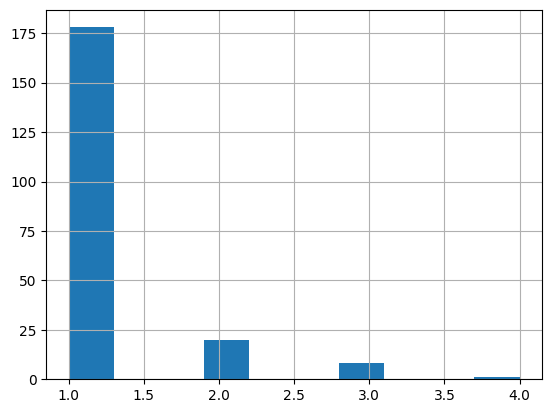

In [25]:
emp_address_counts.hist()

# Check whether all addresses have a unique zip code

## Not quite... there's one address with 2 zips

Let's just ignore that and take the minimum of the two when assigning zipcodes to addresses.

In [26]:
zips_per_address = df_state_table.groupby('address')['zipcode'].nunique()
zips_per_address

address
 100th ave sw  arcadia, fl                1
 109th ave sw  unincorporated, fl         1
 10th street  unincorporated, fl          1
 11th ave ne  cape coral, fl              1
 12th ave  ormond beach, fl               1
                                         ..
w3947 stingle rd  jacksonville, fl        1
w654 greiner rd  titusville, fl           1
w6674 gn willow ct  unincorporated, fl    1
w7426 state highway 33  dunnellon, fl     1
w8581 county rd e  wesley chapel, fl      1
Name: zipcode, Length: 20449, dtype: int64

In [27]:
zips_per_address.value_counts()

1    20448
2        1
Name: zipcode, dtype: int64

In [28]:
zips_per_address.loc[zips_per_address == 2]

address
 main street  unincorporated, fl    2
Name: zipcode, dtype: int64

In [29]:
df_state_table.query("address == ' main street  unincorporated, fl'")

,tracked,middle_name,sex,relation_to_household_head,race_ethnicity,housing_type,exit_time,last_name,state,ssn,...,years_of_life_lost,cause_of_death,zipcode,address,parent_id,last_birth_time,employer_id,employer_name,employer_zipcode,employer_address
13932,True,Brandon,Male,Reference person,Latino,Standard,NaT,Gonzalez,12,056-48-7134,...,0.0,not_dead,33411,"main street unincorporated, fl",-1,NaT,-1,unemployed,NA,NA
13933,True,Jana,Female,Opp-sex spouse,White,Standard,NaT,Richards,12,225-28-2266,...,0.0,not_dead,33411,"main street unincorporated, fl",-1,2019-03-04 18:00:00,-1,unemployed,NA,NA
47375,True,Michael,Male,Reference person,Latino,Standard,NaT,Garcia,12,326-69-8037,...,0.0,not_dead,32818,"main street unincorporated, fl",-1,NaT,93,not implemented,33324,"6450 n hwy 97 plantation, fl"
47376,True,Mercedes,Female,Opp-sex spouse,Latino,Standard,NaT,Garcia,12,567-50-4363,...,0.0,not_dead,32818,"main street unincorporated, fl",-1,2019-03-04 18:00:00,64,not implemented,32244,"35 katie court jacksonville, fl"
47377,True,Mikel,Male,Biological child,Latino,Standard,NaT,Rowland,12,729-49-1167,...,0.0,not_dead,32818,"main street unincorporated, fl",-1,NaT,48,not implemented,32763,"5266 shady rd orange city, fl"
47378,True,Irene,Female,Parent-in-law,Latino,Standard,NaT,Ponce,12,387-77-8308,...,0.0,not_dead,32818,"main street unincorporated, fl",-1,2019-03-04 18:00:00,191,not implemented,33139,"9915 w hope cir miami beach, fl"


In [30]:
address_counts['33411']

62

In [31]:
address_counts['32818']

19

# Get dataframe with mapping of address to cleaned zipcode

Use consecutive integers as ths index so that I can map each address ID from new census data to a number in this dataframe's index via modular arithmetic.

In [32]:
address_to_zip = (
    df_state_table
    .assign(clean_zipcode=clean_zipcode(df_state_table['zipcode']))
    .groupby('address', as_index=False)['clean_zipcode'].min()
)
address_to_zip

,address,clean_zipcode
0,"100th ave sw arcadia, fl",34266
1,"109th ave sw unincorporated, fl",33434
2,"10th street unincorporated, fl",32807
3,"11th ave ne cape coral, fl",33993
4,"12th ave ormond beach, fl",32174
...,...,...
20444,"w3947 stingle rd jacksonville, fl",32225
20445,"w654 greiner rd titusville, fl",32780
20446,"w6674 gn willow ct unincorporated, fl",33498
20447,"w7426 state highway 33 dunnellon, fl",34431


In [33]:
address_to_zip.clean_zipcode.str.len().unique()

array([5])

# Load new census data and WIC data

The census data is missing some fraction of simulants, so we need to make sure we map all the address IDs that appear in WIC but not census.

In [34]:
!ls -l $new_data_dir

total 846760
-rw-r--r-- 1 albrja IHME-Simulationscience 116145705 Feb  2 11:20 decennial_census_observer.csv.bz2
-rw-r--r-- 1 albrja IHME-Simulationscience   1436741 Feb  2 11:20 household_survey_observer_acs.csv.bz2
-rw-r--r-- 1 albrja IHME-Simulationscience   7443547 Feb  2 11:20 household_survey_observer_cps.csv.bz2
-rw-r--r-- 1 albrja IHME-Simulationscience  30294533 Feb  2 11:21 social_security_observer.csv.bz2
-rw-r--r-- 1 albrja IHME-Simulationscience 696671121 Feb  2 11:27 tax_w2_observer.csv.bz2
-rw-r--r-- 1 albrja IHME-Simulationscience  15056759 Feb  2 11:20 wic_observer.csv.bz2


In [35]:
%%time
df_census = pd.read_csv(f'{new_data_dir}/decennial_census_observer.csv.bz2')
df_census

CPU times: user 27.3 s, sys: 1.7 s, total: 29 s
Wall time: 29 s


,simulant_id,last_name_id,age,sex,race_ethnicity,date_of_birth,address_id,guardian_1,guardian_2,guardian_1_address_id,guardian_2_address_id,relation_to_household_head,census_year,housing_type,random_seed,year_of_birth,first_name,middle_initial
0,3254_0,0.0,67.376229,Female,Black,1952-11-15,6,-1,-1,NaN,NaN,Reference person,2020,Standard,3254,1952,Deanna,S
1,3254_1,0.0,37.501003,Male,Black,1982-10-01,6,-1,-1,NaN,NaN,Biological child,2020,Standard,3254,1982,Clifton,S
2,3254_2,0.0,31.157344,Male,Black,1989-02-03,6,-1,-1,NaN,NaN,Biological child,2020,Standard,3254,1989,Christopher,S
3,3254_3,3.0,37.944355,Male,Latino,1982-04-22,7,-1,-1,NaN,NaN,Reference person,2020,Standard,3254,1982,Travis,J
4,3254_4,4.0,60.986418,Male,White,1959-04-07,8,-1,-1,NaN,NaN,Reference person,2020,Standard,3254,1959,Davis,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4943280,3541_278165,44253.0,0.055643,Female,Latino,2030-03-28,150569,44253,-1,150569.0,NaN,Biological child,2030,Standard,3541,2030,Mila,C
4943281,3541_278166,50096.0,0.039506,Female,Black,2030-04-03,3,50097,-1,3.0,NaN,Noninstitutionalized GQ pop,2030,College,3541,2030,Aicha,L
4943282,3541_278167,113377.0,0.052213,Female,Black,2030-03-29,96003,113380,-1,96003.0,NaN,Biological child,2030,Standard,3541,2030,Amila,E
4943283,3541_278168,140942.0,0.016033,Female,Latino,2030-04-12,179963,140944,-1,179963.0,NaN,Grandchild,2030,Standard,3541,2030,Tallulah,S


In [36]:
df_census.dtypes

simulant_id                    object
last_name_id                  float64
age                           float64
sex                            object
race_ethnicity                 object
date_of_birth                  object
address_id                      int64
guardian_1                      int64
guardian_2                      int64
guardian_1_address_id         float64
guardian_2_address_id         float64
relation_to_household_head     object
census_year                     int64
housing_type                   object
random_seed                     int64
year_of_birth                   int64
first_name                     object
middle_initial                 object
dtype: object

In [37]:
df_census.filter(like='zip').columns

Index([], dtype='object')

In [38]:
%%time
df_wic = pd.read_csv(f'{new_data_dir}/wic_observer.csv.bz2')
df_wic

CPU times: user 2.68 s, sys: 15.4 ms, total: 2.69 s
Wall time: 2.69 s


,simulant_id,last_name_id,age,sex,race_ethnicity,date_of_birth,address_id,guardian_1,guardian_2,guardian_1_address_id,guardian_2_address_id,wic_year,random_seed,year_of_birth,first_name,middle_initial
0,7359_65,65.0,8.553950,Female,Black,2012-05-21,35,-1,-1,NaN,NaN,2021,7359,2012,Emma,M
1,7359_116,116.0,25.505874,Female,Black,1995-06-08,53,-1,-1,NaN,NaN,2021,7359,1995,Isabella,A
2,7359_212,211.0,30.291655,Female,Latino,1990-08-25,88,-1,-1,NaN,NaN,2021,7359,1990,Paige,L
3,7359_248,248.0,23.891573,Female,Black,1997-01-18,97912,-1,-1,NaN,NaN,2021,7359,1997,Michelle,M
4,7359_267,266.0,37.072670,Female,White,1983-11-13,109,-1,-1,NaN,NaN,2021,7359,1983,Maria,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593011,5020_277602,231367.0,0.041138,Male,Asian,2030-01-08,152642,231367,-1,152642.0,NaN,2030,5020,2030,Grayson,B
593012,5020_277607,237489.0,0.045699,Male,Latino,2030-01-07,135561,237490,-1,135561.0,NaN,2030,5020,2030,Tanner,E
593013,5020_277612,242914.0,0.039537,Female,Asian,2030-01-09,167694,242914,-1,167694.0,NaN,2030,5020,2030,Madison,S
593014,5020_277617,5210.0,0.054807,Male,Latino,2030-01-03,97484,5214,-1,97484.0,NaN,2030,5020,2030,Gavin,J


In [39]:
df_wic.dtypes

simulant_id               object
last_name_id             float64
age                      float64
sex                       object
race_ethnicity            object
date_of_birth             object
address_id                 int64
guardian_1                 int64
guardian_2                 int64
guardian_1_address_id    float64
guardian_2_address_id    float64
wic_year                   int64
random_seed                int64
year_of_birth              int64
first_name                object
middle_initial            object
dtype: object

# Figure out how to map each address IDs from new census data to an address (hence zipcode) in the original data

The idea is to just mod the address ID by the number of original addresses (20,449), then use the modded ID as the index in the `address_to_zip` map.

Ideally, the address IDs would be consecutive integers up to the maximum ID so that we're guaranteed an approximately uniform mapping into the original addresses (hence zipcodes).

It looks like the census address IDs are not quite consecutive, but there are only 77 values missing between the minimum 0 and the maximum 189,912. Most likely, the address IDs actually _are_ consecutive, and the missing IDs are due to the missing simulants in the census. So probably (hopefully) at least some of these addresses will be present in WIC.

Assuming that's the case, we can look at the maximum of all the address IDs that occur in either the census or WIC data, and assume that every possible address ID is a number between 0 and this maximum (inclusive). After checking below, there are no IDs in WIC that are larger than the max ID of 189,912 in the census, so we use this as the maximum possible ID. Thus we get a mapping of address IDs into the original addresses (hence zipcodes) by taking n mod 20,449 for each n in {0, ..., 189,912}.

## Look at address IDs in census

In [40]:
df_census.address_id.describe()

count    4.943285e+06
mean     7.023635e+04
std      5.381825e+04
min      0.000000e+00
25%      2.655600e+04
50%      6.048500e+04
75%      9.719400e+04
max      1.899120e+05
Name: address_id, dtype: float64

In [41]:
df_census.address_id.nunique()

189836

In [42]:
df_census.address_id.max()+1

189913

In [43]:
189913 - 189836

77

In [44]:
census_nunique = df_census.address_id.nunique()
census_range_length = df_census.address_id.max()+1
print('Census num unique:', census_nunique)
print('Census range length:', census_range_length)
print('Census num missing:', census_range_length - census_nunique)

Census num unique: 189836
Census range length: 189913
Census num missing: 77


## Find missing 77 ids in census

In [45]:
missing_ids = set(range(census_range_length)).difference(df_census.address_id)
print(len(missing_ids))
missing_ids

77


{94072,
 94755,
 96208,
 96228,
 96935,
 97731,
 98171,
 98290,
 98370,
 99418,
 99586,
 99633,
 99638,
 99703,
 99835,
 100210,
 100263,
 100507,
 100930,
 100951,
 101088,
 101227,
 101296,
 101562,
 101921,
 102039,
 102355,
 102479,
 103005,
 103320,
 103338,
 103358,
 103690,
 103872,
 104686,
 105051,
 105120,
 105132,
 105705,
 106251,
 106398,
 106430,
 106917,
 107793,
 107825,
 108311,
 108551,
 109068,
 110228,
 111397,
 111479,
 111762,
 112075,
 112418,
 112754,
 113255,
 114143,
 114459,
 114650,
 114956,
 115346,
 115622,
 115993,
 117351,
 117453,
 119126,
 119187,
 119249,
 119684,
 120792,
 121370,
 122620,
 124067,
 132027,
 133064,
 133341,
 133778}

## Look at address IDs in WIC

In [46]:
wic_nunique = df_wic.address_id.nunique()
wic_range_length = df_wic.address_id.max()+1
print('WIC num unique:', wic_nunique)
print('WIC range length:', wic_range_length)
print('WIC num missing:', wic_range_length - wic_nunique)

WIC num unique: 123789
WIC range length: 187855
WIC num missing: 64066


## 61 of the 77 missing address IDs in the census show up in WIC (note that WIC has 10 years worth of data, 2021-2030)

In [47]:
missing_ids_in_wic = missing_ids.intersection(df_wic.address_id)
print(len(missing_ids_in_wic))
missing_ids_in_wic

61


{96208,
 96228,
 97731,
 98171,
 98290,
 98370,
 99418,
 99586,
 99633,
 99638,
 99703,
 99835,
 100210,
 100263,
 100507,
 100930,
 100951,
 101088,
 101227,
 101296,
 101562,
 101921,
 102039,
 102355,
 102479,
 103005,
 103320,
 103338,
 103690,
 104686,
 105051,
 105120,
 105705,
 106251,
 106430,
 106917,
 107825,
 108311,
 108551,
 109068,
 110228,
 111479,
 111762,
 112418,
 112754,
 113255,
 114143,
 114650,
 114956,
 115622,
 117453,
 119187,
 119249,
 119684,
 120792,
 121370,
 122620,
 124067,
 132027,
 133341,
 133778}

## Find maximum+1 of all address IDs encountered in Census or WIC

The census range maximum is larger than the WIC range maximum, which is the most probable situation.

In [48]:
print(f'{census_range_length=}, {wic_range_length=}')
print('Overall range length = ',
      range_length := max([census_range_length, wic_range_length]),
      '(Census)' if range_length == census_range_length else '(WIC)'
     )

census_range_length=189913, wic_range_length=187855
Overall range length =  189913 (Census)


## Create a mapping from rows in the new census data to zipcodes from the original data

In [49]:
# Use the overall maximum range to create a list of all possible address IDs
all_address_ids = np.arange(range_length)
all_address_ids

array([     0,      1,      2, ..., 189910, 189911, 189912])

In [50]:
# Total number of unique original addresses
len(address_to_zip)

20449

In [51]:
address_id_to_zip = (
    pd.DataFrame(
        {'index_of_orig_address': all_address_ids % len(address_to_zip)},
        index=all_address_ids
    )
    .rename_axis('address_id')
    .join(address_to_zip, on='index_of_orig_address')
    .rename(columns={'address': 'orig_address', 'clean_zipcode': 'zipcode'})
)
address_id_to_zip

,index_of_orig_address,orig_address,zipcode
address_id,,,
0,0,"100th ave sw arcadia, fl",34266
1,1,"109th ave sw unincorporated, fl",33434
2,2,"10th street unincorporated, fl",32807
3,3,"11th ave ne cape coral, fl",33993
4,4,"12th ave ormond beach, fl",32174
...,...,...,...
189908,5867,"1685 nugget ct ft myers, fl",33908
189909,5868,"16852 76th ave jacksonville, fl",32217
189910,5869,"16855 florence vw dr defuniak springs, fl",32433


# Join the zipcodes onto the census data and check distribution

In [52]:
%%time
census_zips = df_census[['address_id']].join(address_id_to_zip, on='address_id')
census_zips

CPU times: user 645 ms, sys: 0 ns, total: 645 ms
Wall time: 644 ms


,address_id,index_of_orig_address,orig_address,zipcode
0,6,6,"13th ave w unincorporated, fl",33462
1,6,6,"13th ave w unincorporated, fl",33462
2,6,6,"13th ave w unincorporated, fl",33462
3,7,7,"13th avenue southwest lakeland, fl",33811
4,8,8,"14th street fern prk, fl",32730
...,...,...,...,...
4943280,150569,7426,"2025 e roosevelt ct kissimmee, fl",34741
4943281,3,3,"11th ave ne cape coral, fl",33993
4943282,96003,14207,"4647 coleherne road winter park, fl",32792
4943283,179963,16371,"605 tce hill ln englewood, fl",34224


In [53]:
census_addresses_per_zip = census_zips.groupby('zipcode')['address_id'].nunique()
census_addresses_per_zip

zipcode
32003    306
32008     46
32009     19
32011     95
32024      9
        ... 
34987     63
34990    249
34994    140
34996    169
34997    260
Name: address_id, Length: 857, dtype: int64

In [54]:
census_addresses_per_zip.value_counts()

9      38
18     18
19     13
46     12
38     12
       ..
179     1
386     1
338     1
340     1
59      1
Name: address_id, Length: 353, dtype: int64

<AxesSubplot: >

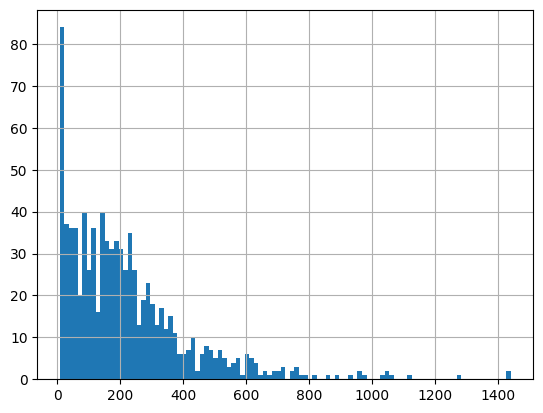

In [55]:
census_addresses_per_zip.hist(bins=100)

In [56]:
census_addresses_per_zip.describe()

count     857.000000
mean      221.512252
std       200.005906
min         9.000000
25%        82.000000
50%       176.000000
75%       299.000000
max      1440.000000
Name: address_id, dtype: float64

In [57]:
df_census.address_id.nunique() / len(address_to_zip)

9.283387940730599

# Join zipcodes onto WIC data and check distribution

In [58]:
wic_zips = df_wic[['address_id']].join(address_id_to_zip, on='address_id')
wic_zips

,address_id,index_of_orig_address,orig_address,zipcode
0,35,35,"420th ave bradenton, fl",34205
1,53,53,"8th st melbourne, fl",32940
2,88,88,"belvedere avenue south west south daytona, fl",32119
3,97912,16116,"5911 chestnut st st. petersburg, fl",33710
4,109,109,"broad jupiter, fl",33458
...,...,...,...,...
593011,152642,9499,"26 putnam road jacksonville, fl",32258
593012,135561,12867,40 putnam circle northeast apt no 101 vero bea...,32960
593013,167694,4102,"1360 cable rd boynton beach, fl",33426
593014,97484,15688,"5554 n pinebay cir port richey, fl",34668


In [59]:
wic_addresses_per_zip = wic_zips.groupby('zipcode')['address_id'].nunique()
wic_addresses_per_zip

zipcode
32003    214
32008     29
32009     10
32011     60
32024      4
        ... 
34987     43
34990    177
34994     96
34996     99
34997    175
Name: address_id, Length: 857, dtype: int64

In [60]:
wic_addresses_per_zip.value_counts()

7      17
5      11
12     11
6      10
99      9
       ..
311     1
461     1
372     1
312     1
177     1
Name: address_id, Length: 330, dtype: int64

<AxesSubplot: >

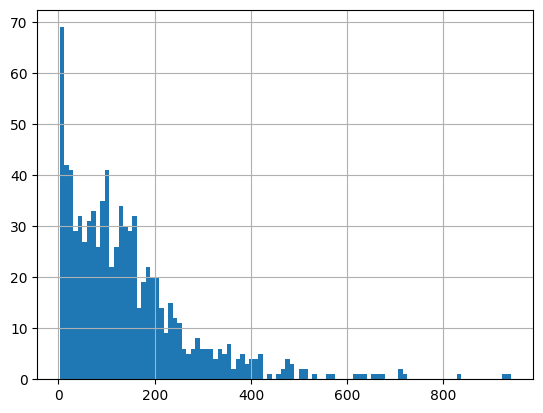

In [61]:
wic_addresses_per_zip.hist(bins=100)

In [62]:
wic_addresses_per_zip.describe()

count    857.000000
mean     144.444574
std      131.022121
min        3.000000
25%       50.000000
50%      116.000000
75%      195.000000
max      940.000000
Name: address_id, dtype: float64

In [63]:
df_wic.address_id.nunique() / len(address_to_zip)

6.053547850750648

# Save zipcode mapping to use later

In [64]:
!ls /share/scratch/users/ndbs/

prl  vivarium_lsff  vivarium_results


In [65]:
%%time
save_dir = '/share/scratch/users/ndbs/prl'
save_filename = 'address_id_to_zipcode_2023_02_02_10_16_21.csv.bz2'
save_filepath = f'{save_dir}/{save_filename}'
address_id_to_zip['zipcode'].to_csv(save_filepath)
!ls -l $save_dir

total 700
-rw-rw-r-- 1 ndbs Domain Users 710226 Feb  9 22:50 address_id_to_zipcode_2023_02_02_10_16_21.csv.bz2
CPU times: user 366 ms, sys: 40.2 ms, total: 406 ms
Wall time: 604 ms


In [66]:
%%time
loaded_zips = pd.read_csv(save_filepath, index_col=0, dtype=str)
loaded_zips

CPU times: user 203 ms, sys: 11.9 ms, total: 214 ms
Wall time: 214 ms


,zipcode
address_id,
0,34266
1,33434
2,32807
3,33993
4,32174
...,...
189908,33908
189909,32217
189910,32433


In [67]:
loaded_zips.dtypes

zipcode    object
dtype: object

In [68]:
loaded_zips.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            189903, 189904, 189905, 189906, 189907, 189908, 189909, 189910,
            189911, 189912],
           dtype='int64', name='address_id', length=189913)